# XGBoost grid search tuning with different feature sets 
- target:'rule4_episode'
## Work subject to continous notebook crashes on CoLab

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
# Python libs
import numpy as np
import pandas as pd
from os.path import isfile, join
import os.path
import re
from google.colab import drive
import sys
import datetime as datetime
import xgboost as xgb
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
import time
import datetime as dt

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [0]:
pd.options.display.float_format = '{:,.3f}'.format # Limit output to 3 decimal places.
pd.set_option('display.max_columns', None)

In [0]:
#drive.mount('/gdrive')
drive.mount('/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# custom scripts
sys.path.append('../gdrive/My Drive/Colab Notebooks')
import data_handler as dh
import feature_handler as fh
import data_processor as dp
import constants as const
import work_utils as wu
import plot_handler as ph
import xgb_handler as xh

In [0]:
data_path = '../gdrive/My Drive/bise_data'

In [0]:
df_merged = pd.read_csv(os.path.join(data_path, 'model_data_all_features_classified.csv.zip'), index_col=0)
df_merged.head()

,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_dir_spread30,KLO_Wind_dir_spread60,KLO_Wind_max_EW,KLO_Wind_max_NS,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed_EW,KLO_Wind_speed_NS,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6,BIZ_Air_temp,BIZ_Hum,BIZ_Hum_delta_3,BIZ_Hum_delta_6,BIZ_QNH,BIZ_Wind_dir,BIZ_Wind_dir_delta,BIZ_Wind_dir_delta-3,BIZ_Wind_dir_delta-6,BIZ_Wind_dir_spread30,BIZ_Wind_dir_spread60,BIZ_Wind_max_EW,BIZ_Wind_max_NS,BIZ_Wind_max,BIZ_Wind_max_delta_3,BIZ_Wind_max_delta_6,BIZ_Wind_speed_EW,BIZ_Wind_speed_NS,BIZ_Wind_speed,BIZ_Wind_speed_delta_3,BIZ_Wind_speed_delta_6,BUS_Air_temp,BUS_Hum,BUS_Hum_delta_3,BUS_Hum_delta_6,BUS_QNH,BUS_Wind_dir,BUS_Wind_dir_delta,BUS_Wind_dir_delta-3,BUS_Wind_dir_delta-6,BUS_Wind_dir_spread30,BUS_Wind_dir_spread60,BUS_Wind_max_EW,BUS_Wind_max_NS,BUS_Wind_max,BUS_Wind_max_delta_3,BUS_Wind_max_delta_6,BUS_Wind_speed_EW,BUS_Wind_speed_NS,BUS_Wind_speed,BUS_Wind_speed_delta_3,BUS_Wind_speed_delta_6,GUT_Air_temp,GUT_Hum,GUT_Hum_delta_3,GUT_Hum_delta_6,GUT_QNH,GUT_Wind_dir,GUT_Wind_dir_delta,GUT_Wind_dir_delta-3,GUT_Wind_dir_delta-6,GUT_Wind_dir_spread30,GUT_Wind_dir_spread60,GUT_Wind_max_EW,GUT_Wind_max_NS,GUT_Wind_max,GUT_Wind_max_delta_3,GUT_Wind_max_delta_6,GUT_Wind_speed_EW,GUT_Wind_speed_NS,GUT_Wind_speed,GUT_Wind_speed_delta_3,GUT_Wind_speed_delta_6,KOP_Air_temp,KOP_Hum,KOP_Hum_delta_3,KOP_Hum_delta_6,KOP_QNH,KOP_Wind_dir,KOP_Wind_dir_delta,KOP_Wind_dir_delta-3,KOP_Wind_dir_delta-6,KOP_Wind_dir_spread30,KOP_Wind_dir_spread60,KOP_Wind_max_EW,KOP_Wind_max_NS,KOP_Wind_max,KOP_Wind_max_delta_3,KOP_Wind_max_delta_6,KOP_Wind_speed_EW,KOP_Wind_speed_NS,KOP_Wind_speed,KOP_Wind_speed_delta_3,KOP_Wind_speed_delta_6,MOA_Air_temp,MOA_Hum,MOA_Hum_delta_3,MOA_Hum_delta_6,MOA_QNH,MOA_Wind_dir,MOA_Wind_dir_delta,MOA_Wind_dir_delta-3,MOA_Wind_dir_delta-6,MOA_Wind_dir_spread30,MOA_Wind_dir_spread60,MOA_Wind_max_EW,MOA_Wind_max_NS,MOA_Wind_max,MOA_Wind_max_delta_3,MOA_Wind_max_delta_6,MOA_Wind_speed_EW,MOA_Wind_speed_NS,MOA_Wind_speed,MOA_Wind_speed_delta_3,MOA_Wind_speed_delta_6,MUB_Air_temp,MUB_Hum,MUB_Hum_delta_3,MUB_Hum_delta_6,MUB_QNH,MUB_Wind_dir,MUB_Wind_dir_delta,MUB_Wind_dir_delta-3,MUB_Wind_dir_delta-6,MUB_Wind_dir_spread30,MUB_Wind_dir_spread60,MUB_Wind_max_EW,MUB_Wind_max_NS,MUB_Wind_max,MUB_Wind_max_delta_3,MUB_Wind_max_delta_6,MUB_Wind_speed_EW,MUB_Wind_speed_NS,MUB_Wind_speed,MUB_Wind_speed_delta_3,MUB_Wind_speed_delta_6,PAY_Air_temp,PAY_Hum,PAY_Hum_delta_3,PAY_Hum_delta_6,PAY_QNH,PAY_Wind_dir,PAY_Wind_dir_delta,PAY_Wind_dir_delta-3,PAY_Wind_dir_delta-6,PAY_Wind_dir_spread30,PAY_Wind_dir_spread60,PAY_Wind_max_EW,PAY_Wind_max_NS,PAY_Wind_max,PAY_Wind_max_delta_3,PAY_Wind_max_delta_6,PAY_Wind_speed_EW,PAY_Wind_speed_NS,PAY_Wind_speed,PAY_Wind_speed_delta_3,PAY_Wind_speed_delta_6,PUY_Air_temp,PUY_Hum,PUY_Hum_delta_3,PUY_Hum_delta_6,PUY_QNH,PUY_Wind_dir,PUY_Wind_dir_delta,PUY_Wind_dir_delta-3,PUY_Wind_dir_delta-6,PUY_Wind_dir_spread30,PUY_Wind_dir_spread60,PUY_Wind_max_EW,PUY_Wind_max_NS,PUY_Wind_max,PUY_Wind_max_delta_3,PUY_Wind_max_delta_6,PUY_Wind_speed_EW,PUY_Wind_speed_NS,PUY_Wind_speed,PUY_Wind_speed_delta_3,PUY_Wind_speed_delta_6,REH_Air_temp,REH_Hum,REH_Hum_delta_3,REH_Hum_delta_6,REH_QNH,REH_Wind_dir,REH_Wind_dir_delta,REH_Wind_dir_delta-3,REH_Wind_dir_delta-6,REH_Wind_dir_spread30,REH_Wind_dir_spread60,REH_Wind_max_EW,REH_Wind_max_NS,REH_Wind_max,REH_Wind_max_delta_3,REH_Wind_max_delta_6,REH_Wind_speed_EW,REH_Wind_speed_NS,REH_Wind_speed,REH_Wind_speed_delta_3,REH_Wind_speed_delta_6,SHA_Air_temp,SHA_Hum,SHA_Hum_delta_3,SHA_Hum_delta_6,SHA_QNH,SHA_Wind_dir,SHA_Wind_dir_delta,SHA_Wind_dir_delta-3,SHA_Wind_dir_delta-6,SHA_Wind_dir_spre

In [0]:
cols_all_features = [c for c in df_merged.columns if re.search('^[A-Z]{3}_', c)] 
len(cols_all_features)

816

In [0]:
cols_base_features = [c for c in cols_all_features if re.search('KLO', c) or re.search('Wind_dir_', c)]
print(len(cols_base_features))
cols_base_features

156


['KLO_Air_temp',
 'KLO_Hum',
 'KLO_Hum_delta_3',
 'KLO_Hum_delta_6',
 'KLO_QNH',
 'KLO_Wind_dir',
 'KLO_Wind_dir_delta',
 'KLO_Wind_dir_delta-3',
 'KLO_Wind_dir_delta-6',
 'KLO_Wind_dir_spread30',
 'KLO_Wind_dir_spread60',
 'KLO_Wind_max_EW',
 'KLO_Wind_max_NS',
 'KLO_Wind_max',
 'KLO_Wind_max_delta_3',
 'KLO_Wind_max_delta_6',
 'KLO_Wind_speed_EW',
 'KLO_Wind_speed_NS',
 'KLO_Wind_speed',
 'KLO_Wind_speed_delta_3',
 'KLO_Wind_speed_delta_6',
 'BIZ_Wind_dir_delta',
 'BIZ_Wind_dir_delta-3',
 'BIZ_Wind_dir_delta-6',
 'BIZ_Wind_dir_spread30',
 'BIZ_Wind_dir_spread60',
 'BUS_Wind_dir_delta',
 'BUS_Wind_dir_delta-3',
 'BUS_Wind_dir_delta-6',
 'BUS_Wind_dir_spread30',
 'BUS_Wind_dir_spread60',
 'GUT_Wind_dir_delta',
 'GUT_Wind_dir_delta-3',
 'GUT_Wind_dir_delta-6',
 'GUT_Wind_dir_spread30',
 'GUT_Wind_dir_spread60',
 'KOP_Wind_dir_delta',
 'KOP_Wind_dir_delta-3',
 'KOP_Wind_dir_delta-6',
 'KOP_Wind_dir_spread30',
 'KOP_Wind_dir_spread60',
 'MOA_Wind_dir_delta',
 'MOA_Wind_dir_delta-3',
 'MOA

In [0]:
# drop first 6 rows, having NaNs
df_merged = df_merged[6:]
df_base_train = df_merged[df_merged.year > 2014]
df_base_test = df_merged[df_merged.year == 2014]

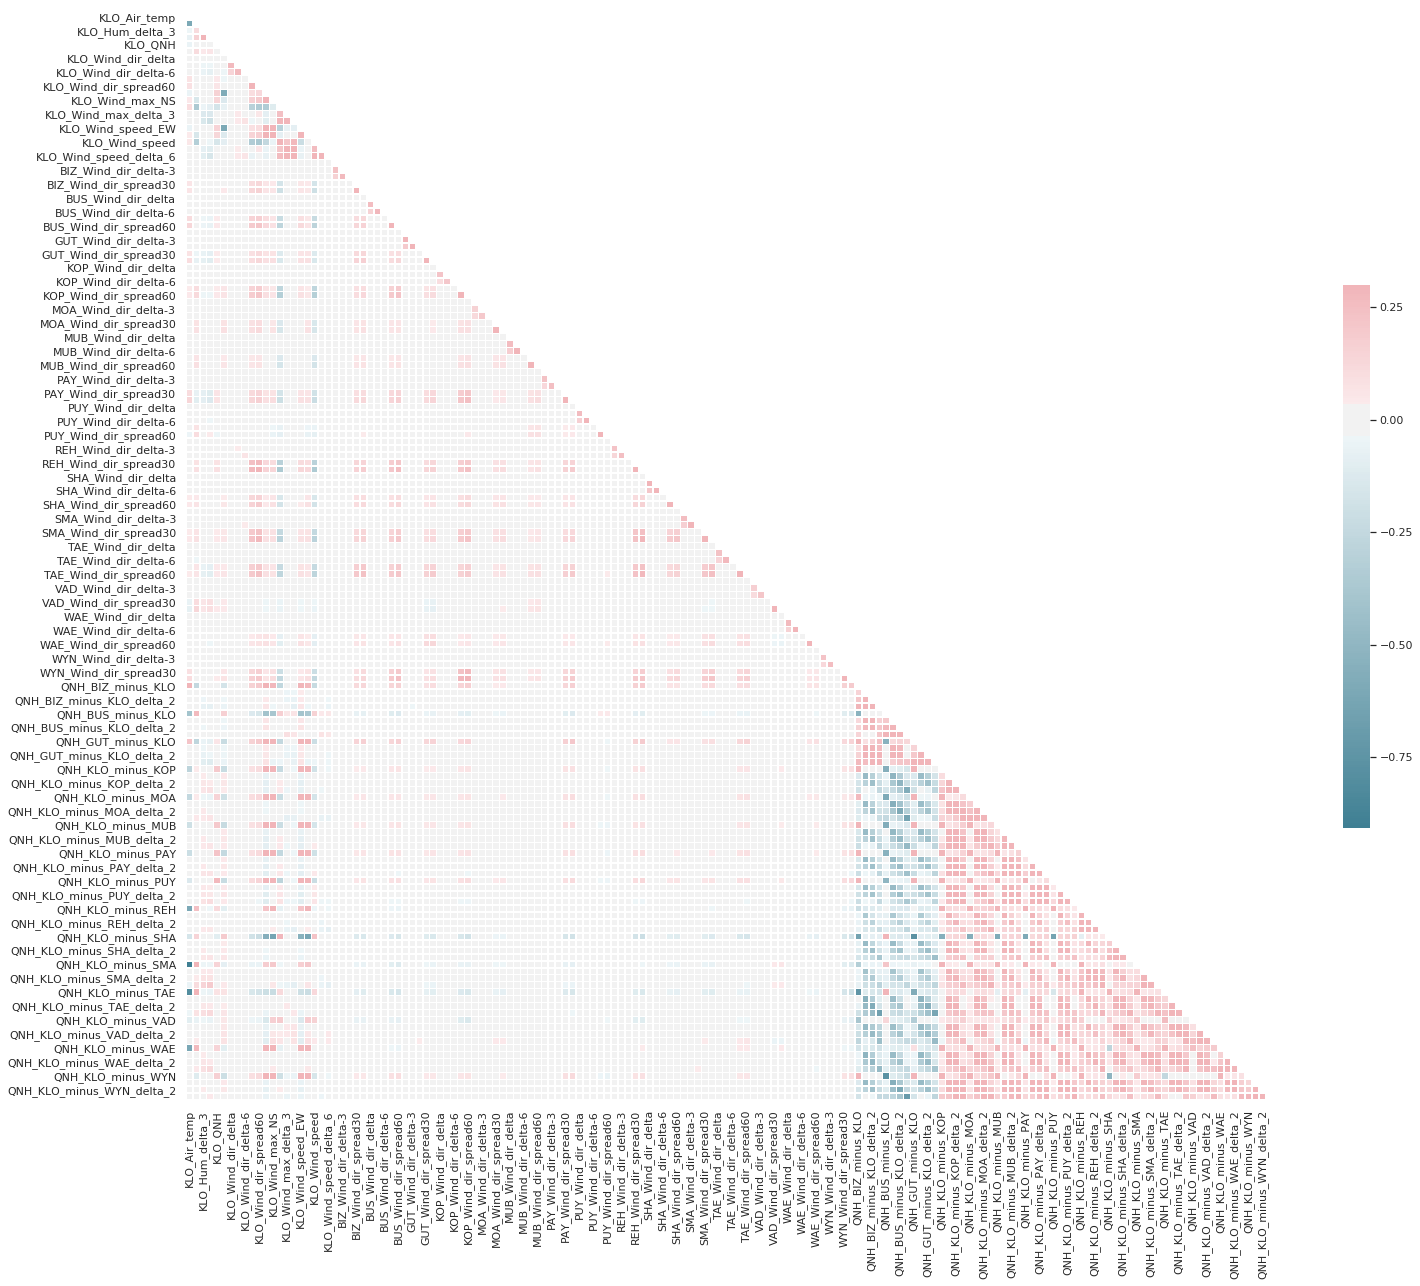

In [0]:
ph.plot_correlation_map(df_merged[cols_base_features])

In [0]:
corr = df_merged[cols_base_features].corr()

correlated_features1 = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
          print(corr.columns[i], corr.columns[j])
          colname = corr.columns[i]
          correlated_features1.add(colname)
          
correlated_features1

KLO_Wind_dir_spread60 KLO_Wind_dir_spread30
KLO_Wind_speed_EW KLO_Wind_max_EW
KLO_Wind_speed_NS KLO_Wind_max_NS
KLO_Wind_speed KLO_Wind_max
KLO_Wind_speed_delta_3 KLO_Wind_max_delta_3
KLO_Wind_speed_delta_6 KLO_Wind_max_delta_6
BIZ_Wind_dir_spread60 BIZ_Wind_dir_spread30
BUS_Wind_dir_spread60 BUS_Wind_dir_spread30
GUT_Wind_dir_spread60 GUT_Wind_dir_spread30
KOP_Wind_dir_spread60 KOP_Wind_dir_spread30
MOA_Wind_dir_spread60 MOA_Wind_dir_spread30
MUB_Wind_dir_spread60 MUB_Wind_dir_spread30
PAY_Wind_dir_spread60 PAY_Wind_dir_spread30
PUY_Wind_dir_spread60 PUY_Wind_dir_spread30
REH_Wind_dir_spread60 REH_Wind_dir_spread30
SHA_Wind_dir_spread60 SHA_Wind_dir_spread30
SMA_Wind_dir_spread60 SMA_Wind_dir_spread30
TAE_Wind_dir_spread60 TAE_Wind_dir_spread30
VAD_Wind_dir_spread60 VAD_Wind_dir_spread30
WAE_Wind_dir_spread60 WAE_Wind_dir_spread30
WYN_Wind_dir_spread60 WYN_Wind_dir_spread30
QNH_GUT_minus_KLO QNH_BIZ_minus_KLO
QNH_GUT_minus_KLO_delta_6 QNH_BIZ_minus_KLO_delta_6
QNH_KLO_minus_MOA QNH_KL

{'BIZ_Wind_dir_spread60',
 'BUS_Wind_dir_spread60',
 'GUT_Wind_dir_spread60',
 'KLO_Wind_dir_spread60',
 'KLO_Wind_speed',
 'KLO_Wind_speed_EW',
 'KLO_Wind_speed_NS',
 'KLO_Wind_speed_delta_3',
 'KLO_Wind_speed_delta_6',
 'KOP_Wind_dir_spread60',
 'MOA_Wind_dir_spread60',
 'MUB_Wind_dir_spread60',
 'PAY_Wind_dir_spread60',
 'PUY_Wind_dir_spread60',
 'QNH_GUT_minus_KLO',
 'QNH_GUT_minus_KLO_delta_6',
 'QNH_KLO_minus_MOA',
 'QNH_KLO_minus_MUB',
 'QNH_KLO_minus_PAY',
 'QNH_KLO_minus_PUY',
 'QNH_KLO_minus_SMA',
 'QNH_KLO_minus_TAE',
 'QNH_KLO_minus_WYN',
 'QNH_KLO_minus_WYN_delta_6',
 'REH_Wind_dir_spread60',
 'SHA_Wind_dir_spread60',
 'SMA_Wind_dir_spread60',
 'TAE_Wind_dir_spread60',
 'VAD_Wind_dir_spread60',
 'WAE_Wind_dir_spread60',
 'WYN_Wind_dir_spread60'}

In [0]:
correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
          print(corr.columns[i], corr.columns[j])
          colname = corr.columns[i]
          correlated_features.add(colname)
correlated_features

KLO_Wind_speed_EW KLO_Wind_max_EW
KLO_Wind_speed_NS KLO_Wind_max_NS
KLO_Wind_speed KLO_Wind_max
QNH_KLO_minus_MUB QNH_KLO_minus_KOP
QNH_KLO_minus_PAY QNH_KLO_minus_KOP
QNH_KLO_minus_PAY QNH_KLO_minus_MUB
QNH_KLO_minus_PUY QNH_KLO_minus_MUB
QNH_KLO_minus_PUY QNH_KLO_minus_PAY
QNH_KLO_minus_SMA KLO_Air_temp


{'KLO_Wind_speed',
 'KLO_Wind_speed_EW',
 'KLO_Wind_speed_NS',
 'QNH_KLO_minus_MUB',
 'QNH_KLO_minus_PAY',
 'QNH_KLO_minus_PUY',
 'QNH_KLO_minus_SMA'}

In [0]:
print(df_base_train.shape, df_base_test.shape)

(210241, 832) (52554, 832)


In [0]:
target_col = 'rule4_episode'

In [0]:
val_count = df_base_train.rule4_episode.value_counts()
neg_pos_ratio = val_count[0] / val_count[1]
print(val_count, neg_pos_ratio)

0    202419
1      7822
Name: rule4_episode, dtype: int64 25.878164152390692


In [0]:
cols_kloten = [c for c in df_merged.columns if re.search('KLO', c)]

In [0]:
df_train_x = df_base_train[cols_kloten]
df_train_y = df_base_train[target_col]
df_test_x = df_base_test[cols_kloten]
df_test_y = df_base_test[target_col]

In [0]:
def grid_search(X,Y,X_test,Y_test, scoring='roc_auc', **hyperparams):
  
  folds = 3
  param_comb = 5

  skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
  print(skf.split(X,Y))

  # Sometimes GPU not available
  #model = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, max_bin=16)
  model = xgb.XGBClassifier(max_bin=16)


  #clf = RandomizedSearchCV(clf_xgb, hyperparams = hyperparams, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)
  grid = GridSearchCV(estimator=model, param_grid=hyperparams, scoring='roc_auc', n_jobs=2, cv=skf.split(X,Y), verbose=3, error_score=0)
  grid.fit(X, Y)
  print('\n All results:')
  print(grid.cv_results_)
  print('\n Best estimator:')
  print(grid.best_estimator_)
  print('\n Best score:')
  print(grid.best_score_ * 2 - 1)
  print('\n Best parameters:')
  print(grid.best_params_)
  results = pd.DataFrame(grid.cv_results_)
  results.to_csv(os.path.join(data_path, 'xgb-grid-search-results_' + str(time.time()) + '.csv'), index=False)

  y_test = grid.best_estimator_.predict(X_test)
  results_df = pd.DataFrame(data={'true_val':Y_test, 'probas':y_test[:,1]})
  results_df.to_csv(os.path.join(data_path, 'submission-grid-search-xgb-' + str(time.time()) + '.csv'), index=False)
  
  return grid.cv_results_, grid.best_estimator_, grid.best_score_, grid.best_params_

"""
  def xgb_cross_validation1(x_train, y_train, **hyperparams):
  n_folds = 5
  early_stopping = 10
  
  xg_train = xgb.DMatrix(x_train, label=y_train);

  return xgb.cv(hyperparams, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1, seed=42) 
"""

'\n  def xgb_cross_validation1(x_train, y_train, **hyperparams):\n  n_folds = 5\n  early_stopping = 10\n  \n  xg_train = xgb.DMatrix(x_train, label=y_train);\n\n  return xgb.cv(hyperparams, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1, seed=42) \n'

In [0]:
hyperparams = {"scale_pos_weight": [neg_pos_ratio, 50],
                  "n_estimators": [200, 400],
                  "eta": [0.001, 0.02],
                  'objective': ['binary:logistic']
                  }

In [0]:
results1, estimator1, best_score1, best_params1 = grid_search(df_train_x, df_train_y, df_test_x, df_test_y,scoring='roc_auc', **hyperparams)

<generator object _BaseKFold.split at 0x7f6869b1a780>
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  2.0min finished



 All results:
{'mean_fit_time': array([ 5.89465094,  6.16537062, 11.9542981 , 12.0755655 ,  5.4126521 ,
        5.69110711, 11.59692128, 11.89444041]), 'std_fit_time': array([1.25994009, 1.2101176 , 1.38492637, 1.21479619, 1.20761744,
       1.22165267, 1.22866764, 1.22504918]), 'mean_score_time': array([0.22233915, 0.21752755, 0.23986252, 0.22811548, 0.22843393,
       0.21915833, 0.24952046, 0.22170361]), 'std_score_time': array([0.02067747, 0.00904493, 0.00819466, 0.00960432, 0.00171206,
       0.01681933, 0.00874884, 0.02166748]), 'param_eta': masked_array(data=[0.001, 0.001, 0.001, 0.001, 0.02, 0.02, 0.02, 0.02],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[200, 200, 400, 400, 200, 200, 400, 400],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_objective': masked_array(data=['

In [0]:
df_results = pd.read_csv(os.path.join(data_path, 'xgb-grid-search-results-01.csv'))
df_results.tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_n_estimators,param_objective,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,12.076,1.215,0.228,0.010,0.001,400,binary:logistic,50.000,"{'eta': 0.001, 'n_estimators': 400, 'objective...",0.997,0.996,0.996,0.996,0.000,3
4,5.413,1.208,0.228,0.002,0.020,200,binary:logistic,25.878,"{'eta': 0.02, 'n_estimators': 200, 'objective'...",0.996,0.996,0.996,0.996,0.000,5
5,5.691,1.222,0.219,0.017,0.020,200,binary:logistic,50.000,"{'eta': 0.02, 'n_estimators': 200, 'objective'...",0.996,0.996,0.996,0.996,0.000,7
6,11.597,1.229,0.250,0.009,0.020,400,binary:logistic,25.878,"{'eta': 0.02, 'n_estimators': 400, 'objective'...",0.997,0.996,0.997,0.996,0.000,1
7,11.894,1.225,0.222,0.022,0.020,400,binary:logistic,50.000,"{'eta': 0.02, 'n_estimators': 400, 'objective'...",0.997,0.996,0.996,0.996,0.000,3


In [0]:
df_results.sort_values(by=['rank_test_score'], inplace = True)
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_n_estimators,param_objective,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,11.954,1.385,0.240,0.008,0.001,400,binary:logistic,25.878,"{'eta': 0.001, 'n_estimators': 400, 'objective...",0.997,0.996,0.997,0.996,0.000,1
6,11.597,1.229,0.250,0.009,0.020,400,binary:logistic,25.878,"{'eta': 0.02, 'n_estimators': 400, 'objective'...",0.997,0.996,0.997,0.996,0.000,1
3,12.076,1.215,0.228,0.010,0.001,400,binary:logistic,50.000,"{'eta': 0.001, 'n_estimators': 400, 'objective...",0.997,0.996,0.996,0.996,0.000,3
7,11.894,1.225,0.222,0.022,0.020,400,binary:logistic,50.000,"{'eta': 0.02, 'n_estimators': 400, 'objective'...",0.997,0.996,0.996,0.996,0.000,3
0,5.895,1.260,0.222,0.021,0.001,200,binary:logistic,25.878,"{'eta': 0.001, 'n_estimators': 200, 'objective...",0.996,0.996,0.996,0.996,0.000,5


In [0]:
best_params1 = df_results.params.iloc[:2,]
best_params1

mean_fit_time
11.954    {'eta': 0.001, 'n_estimators': 400, 'objective...
11.597    {'eta': 0.02, 'n_estimators': 400, 'objective'...
Name: params, dtype: object

In [0]:
best_params2 = df_results[df_results.rank_test_score == 1].params.tolist()
best_params2

["{'eta': 0.001, 'n_estimators': 400, 'objective': 'binary:logistic', 'scale_pos_weight': 25.878164152390692}",
 "{'eta': 0.02, 'n_estimators': 400, 'objective': 'binary:logistic', 'scale_pos_weight': 25.878164152390692}"]

In [0]:
df_probas = pd.read_csv(os.path.join(data_path, 'submission-grid-search-xgb-porto-01.csv'), index_col=0)
df = df_probas[df_probas.index == 1]
df = df.set_index([pd.Index(range(len(df)))])
df.sample(5)

,probas
517,0.985
316,0.986
195,0.999
367,0.772
932,0.992


In [0]:
def run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, dump_dir=None, **hyperparams):
    """Runs a single xgboost classification"""

    return run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, pred_period=None, dump_dir=dump_dir, hyperparams=hyperparams)


def run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, pred_period=None, dump_dir=None, **hyperparams):
    """Runs a single xgboost classification. If pred_period is set, the y_data will be shifted by pred_period rows"""

    reg = xgb.XGBClassifier()
    reg.set_params(**hyperparams)

    X_train = df_train_x
    y_train = df_train_y

    X_test = df_test_x
    y_test = df_test_y

    if pred_period:

        X_train = df_train_x[:-pred_period]
        y_train = df_train_y[pred_period:]

        X_test = df_test_x[:-pred_period]
        y_test = df_test_y[pred_period:]

    reg.fit(X_train, y_train, verbose=2)

    y_pred = reg.predict(X_test)

    prec_score, rec_score, f_score = xh.get_scores(y_test, y_pred)

    print(classification_report(y_test, y_pred))

    if dump_dir:
        file_path = join(dump_dir, 'xgb_no_tuning_single_pred' + str(time.time()) + '.dat')
        print(f'saving to {file_path}')
        pickle.dump(reg, open(file_path, "wb"))

    cm = None

    try:
        cm = confusion_matrix(y_test, y_pred)
    except:
        print('Confusion Matrix crash!!!')
        print(type(y_test), type(y_pred))
        
    return reg, prec_score, rec_score, f_score, cm, y_pred


In [0]:
start = wu.timer()
reg1, prec_score1, rec_score1, f_score1, cm1 = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y,hyperparams={'eta': 0.001, 'n_estimators': 400, 'objective': 'binary:logistic', 'scale_pos_weight': 25.878164152390692})
wu.timer(start)

precision score: 0.895497
recall score: 0.822795
f1 score: 0.857608
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51273
           1       0.90      0.82      0.86      1281

    accuracy                           0.99     52554
   macro avg       0.95      0.91      0.93     52554
weighted avg       0.99      0.99      0.99     52554


 Time taken: 0 hours 1 minutes and 4.98 seconds.


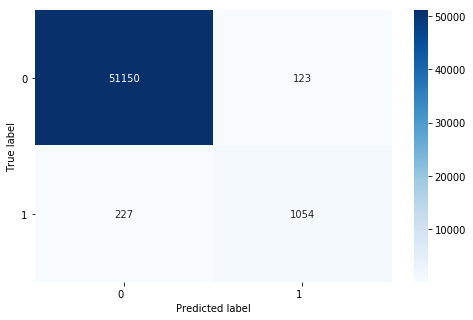

In [0]:
ph.print_confusion_matrix(cm1[0], [0,1], figsize=(8, 5), fontsize=10)

In [0]:
start = wu.timer()
reg2, prec_score2, rec_score2, f_score2, cm2, y_pred2 = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y,hyperparams={'eta': 0.02, 'n_estimators': 400, 'objective': 'binary:logistic', 'scale_pos_weight': 25.878164152390692})
wu.timer(start)

precision score: 0.895497
recall score: 0.822795
f1 score: 0.857608
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51273
           1       0.90      0.82      0.86      1281

    accuracy                           0.99     52554
   macro avg       0.95      0.91      0.93     52554
weighted avg       0.99      0.99      0.99     52554


 Time taken: 0 hours 1 minutes and 4.47 seconds.


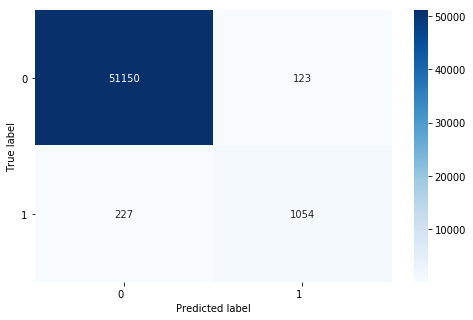

In [0]:
ph.print_confusion_matrix(cm2, [0,1], figsize=(8, 5), fontsize=10)

In [0]:
#signiture changed espect to above
reg3, prec_score3, rec_score3, f_score3, cm3, y_pred3 = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, hyperparams={})

precision score: 0.895497
recall score: 0.822795
f1 score: 0.857608
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51273
           1       0.90      0.82      0.86      1281

    accuracy                           0.99     52554
   macro avg       0.95      0.91      0.93     52554
weighted avg       0.99      0.99      0.99     52554



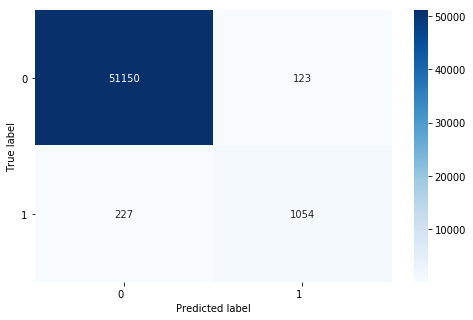

In [0]:
ph.print_confusion_matrix(cm3, [0,1], figsize=(8, 5), fontsize=10)

In [0]:

#[df_probas['true'] == 1].tail()

,probas
557,0.998
397,0.986
57,0.996
971,0.949
1152,0.991


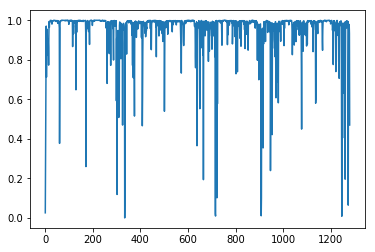

In [0]:
plt.plot(df['probas'])

In [0]:
hyperparams = {"scale_pos_weight": [neg_pos_ratio],
                  "n_estimators": [400],
                  "eta": [0.001, 0.02],
                  "learning-rate": [0.0001, 0.001, 0.1],
                  'objective': ['binary:logistic']
                  }

df_train_x = df_base_train[cols_base_features]
df_train_y = df_base_train[target_col]
df_test_x = df_base_test[cols_base_features]
df_test_y = df_base_test[target_col]

X_train = df_train_x[:-const.steps_20_mins]
y_train = df_train_y[const.steps_20_mins:]

X_test = df_test_x[:-const.steps_20_mins]
y_test = df_test_y[const.steps_20_mins:]
results2, estimator2, best_score2, best_params2 = grid_search(X_train, y_train, X_test, y_test,scoring='roc_auc', **hyperparams)

<generator object _BaseKFold.split at 0x7f0f40dfa678>
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
import multiprocessing

multiprocessing.cpu_count()

2

In [0]:
 Best parameters:
{'eta': 0.02, 'n_estimators': 200, 'objective': 'binary:logistic', 'scale_pos_weight': 25.878164152390692}

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.02, gamma=0,
              gpu_id=0, learning_rate=0.1, max_bin=16, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
              n_jobs=1, nthread=None, objective='binary:logistic',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=25.878164152390692, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)


In [0]:
df_train_x = df_base_train[cols_base_features]
df_train_y = df_base_train[target_col]
df_test_x = df_base_test[cols_base_features]
df_test_y = df_base_test[target_col]

In [0]:
hyperparams = {"scale_pos_weight": [10, neg_pos_ratio, 50],
                  "n_estimators": range(10, 200, 10),
                  "eta": [0.02, 0.05, 0.1],
                  "max_depth": range(1, 10),
                  "subsample": [0.4, 0.7, 0.9],
                  "colsample_bytree": [0.3, 0.5, 1],
                  "gamma": [0, 1, 5],
                  'gpu_id': [0], 
                  'objective': ['binary:logistic']
                  }

In [0]:
results, estimator, best_score, best_params = grid_search(df_train_x, df_train_y, scoring='roc_auc', **hyperparams)

Fitting 3 folds for each of 41553 candidates, totalling 124659 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 12.7min


In [0]:
xgb_cross_validation1(df_train_x, df_train_y, **hyperparams)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBoostError: ignored